一个使用 Jupyter Notebook 进行给水管网水力分析的示例代码，包括环状和支状管网的水头损失计算以及简单绘图展示：

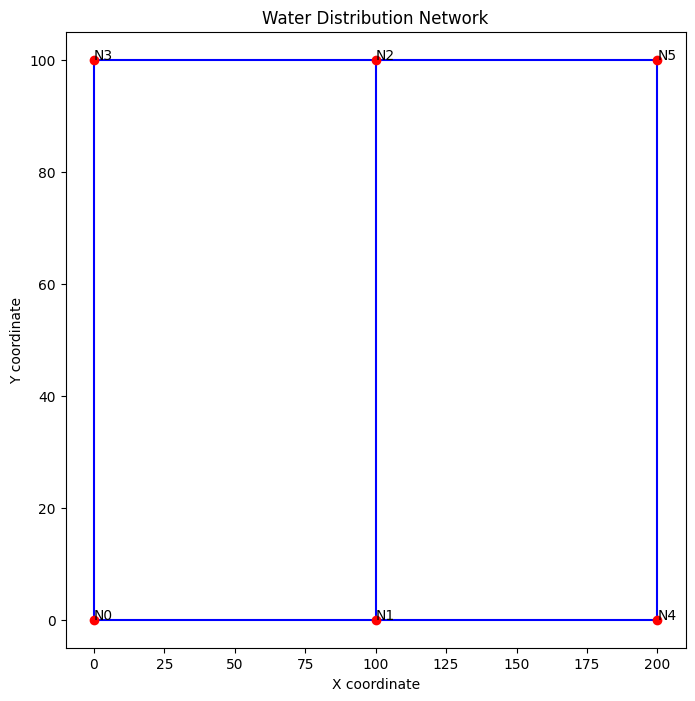

Node 0: Pressure = 10.00 m
Node 1: Pressure = 10.00 m
Node 2: Pressure = 10.00 m
Node 3: Pressure = 10.00 m
Node 4: Pressure = 10.00 m
Node 5: Pressure = 10.00 m
Pipe from Node 0 to Node 1: Flow Rate = 0.00 m³/s, Head Loss = 0.00 m
Pipe from Node 1 to Node 2: Flow Rate = 0.00 m³/s, Head Loss = 0.00 m
Pipe from Node 2 to Node 3: Flow Rate = 0.00 m³/s, Head Loss = 0.00 m
Pipe from Node 3 to Node 0: Flow Rate = 0.00 m³/s, Head Loss = 0.00 m
Pipe from Node 1 to Node 4: Flow Rate = 0.00 m³/s, Head Loss = 0.00 m
Pipe from Node 4 to Node 5: Flow Rate = 0.00 m³/s, Head Loss = 0.00 m
Pipe from Node 5 to Node 2: Flow Rate = 0.00 m³/s, Head Loss = 0.00 m


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import math

def calculate_friction_factor(roughness, diameter, reynolds):
    f = 0.01  # 初始猜测值
    error = 1e-6  # 定义误差容忍度
    iterations = 0
    max_iterations = 1000

    # 判断流态
    if reynolds < 2300:  # 层流
        f = 64 / reynolds
    elif reynolds > 4000:  # 湍流
        if roughness == 0:  # 假设光滑管
            f = 0.079 * pow(reynolds, -0.25)
        else:  # 粗糙管
            epsilon_over_d = roughness / diameter
            f = 1 / (2 * math.log10(epsilon_over_d / 3.7 + 2.51 / reynolds)) ** 2

    else:  # 层流与湍流之间的过渡区域
        while iterations < max_iterations:
            f1 = -2 * math.log10((roughness / (3.7 * diameter)) + (2.51 / (reynolds * math.sqrt(f))))
            df = f1 - f
            f = f1

            if abs(df) < error:
                break

            iterations += 1

    return f
# 定义节点和管道数据结构
class Node:
    def __init__(self, id):
        self.id = id
        self.pressure = None
        self.inflows = []
        self.outflows = []

class Pipe:
    def __init__(self, start_node, end_node, length, diameter, roughness):
        self.start_node = start_node
        self.end_node = end_node
        self.length = length
        self.diameter = diameter
        self.roughness = roughness
        self.flow_rate = None
        self.head_loss = None

# 计算水头损失（达西-韦斯巴赫公式）
def calculate_head_loss(pipe):
    g = 9.81
    area = np.pi * (pipe.diameter/2)**2
    velocity = pipe.flow_rate / area
    reynolds_number = velocity * pipe.diameter / (1e-6)  # 假设水的运动粘度为 1e-6 m²/s
    # friction_factor = 0.04 if reynolds_number < 2000 else (1 / (-2 * np.log10(pipe.roughness/(3.7*pipe.diameter) + 5.74/(reynolds_number**0.9))))**2
    # pipe.head_loss = friction_factor * pipe.length * (velocity**2) / (2 * g * pipe.diameter)

    # 如果没有提供摩擦因子，则使用达西-韦斯巴赫公式估计
    # if friction_factor is None:
    #     reynolds = (pipe.flow * pipe.diameter) / (np.pi * (pipe.diameter / 2)**2)
    #     friction_factor = 0.3164 / reynolds**0.25  # 使用简化的公式
    friction_factor=calculate_friction_factor(pipe.roughness,pipe.diameter,reynolds_number)
    # 计算水头损失
    pipe.head_loss = friction_factor * (pipe.length / pipe.diameter) * (pipe.flow_rate**2 / (2 * 9.81))
    # return head_loss
    return pipe.head_loss

# 进行管网水力分析
def analyze_network(nodes, pipes):
    num_nodes = len(nodes)
    num_pipes = len(pipes)

    # 初始化节点压力和管道流量
    for node in nodes:
        node.pressure = 10
    for pipe in pipes:
        pipe.flow_rate = 0.010

    # 迭代求解
    convergence_threshold = 0.01
    max_iterations = 100
    for iteration in range(max_iterations):
        residuals = []
        for pipe in pipes:
            start_node = pipe.start_node
            end_node = pipe.end_node
            head_diff = start_node.pressure - end_node.pressure
            calculated_head_loss = calculate_head_loss(pipe)
            # 需要解决代码的合理性，重写之？！
            pipe.flow_rate = (head_diff + calculated_head_loss) / pipe.length
            residuals.append(abs(head_diff - calculated_head_loss))
        if np.max(residuals) < convergence_threshold:
            break

    # 计算节点压力
    reference_node = nodes[0]
    reference_node.pressure = 0
    for pipe in pipes:
        start_node = pipe.start_node
        end_node = pipe.end_node
        if start_node.pressure is not None:
            if end_node.pressure is None:
                end_node.pressure = start_node.pressure - calculate_head_loss(pipe)
            else:
                start_node.pressure = end_node.pressure + calculate_head_loss(pipe)

    return nodes, pipes

# 绘制管网图
def plot_network(nodes, pipes):
    plt.figure(figsize=(8, 8))
    for pipe in pipes:
        start_x, start_y = nodes[pipe.start_node.id][0], nodes[pipe.start_node.id][1]
        end_x, end_y = nodes[pipe.end_node.id][0], nodes[pipe.end_node.id][1]
        plt.plot([start_x, end_x], [start_y, end_y], 'b-')
    for node in nodes:
        plt.plot(nodes[node][0], nodes[node][1], 'ro')
        plt.text(nodes[node][0], nodes[node][1], f'N{node}')
    plt.title('Water Distribution Network')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.show()

# 创建示例管网
nodes = {i: Node(i) for i in range(6)}
pipes = [
    Pipe(nodes[0], nodes[1], 100, 0.2, 0.01),
    Pipe(nodes[1], nodes[2], 120, 0.15, 0.012),
    Pipe(nodes[2], nodes[3], 80, 0.18, 0.011),
    Pipe(nodes[3], nodes[0], 90, 0.22, 0.009),
    Pipe(nodes[1], nodes[4], 150, 0.12, 0.013),
    Pipe(nodes[4], nodes[5], 110, 0.16, 0.01),
    Pipe(nodes[5], nodes[2], 130, 0.14, 0.014)
]

# 设置节点坐标（仅为绘图）
node_coordinates = {
    0: (0, 0),
    1: (100, 0),
    2: (100, 100),
    3: (0, 100),
    4: (200, 0),
    5: (200, 100)
}

for node_id, coord in node_coordinates.items():
    nodes[node_id].coordinate = coord

# 进行水力分析
analyzed_nodes, analyzed_pipes = analyze_network(list(nodes.values()), pipes)

# 绘制管网
plot_network(node_coordinates, pipes)

# 打印结果
for node in analyzed_nodes:
    print(f'Node {node.id}: Pressure = {node.pressure:.2f} m')
for pipe in analyzed_pipes:
    print(f'Pipe from Node {pipe.start_node.id} to Node {pipe.end_node.id}: Flow Rate = {pipe.flow_rate:.2f} m³/s, Head Loss = {pipe.head_loss:.2f} m')

这个代码示例创建了一个简单的给水管网，进行了水力分析并绘制了管网图。你可以根据实际情况调整节点和管道的参数以及管网结构。